## Table of Contents
* [Introduction](#Introduction)
* [Database Exploration](#Database-Exploration)
* [Face Recognition](#Face-Recognition)
* [Evaluation](#Evaluation)


## Introduction

The Avengers franchise has taken the world by storm, captivating audiences with its action-packed superhero movies and beloved characters. Among these characters are the iconic heroes portrayed by Chris Evans, Chris Hemsworth, Mark Ruffalo, Robert Downey Jr., and Scarlett Johansson. Recognizing the importance of these actors to the franchise, we have developed a face recognition project that uses the power of artificial intelligence and the DeepFace library to accurately identify and distinguish between these individuals. Our project aims to showcase the impressive capabilities of facial recognition technology and its potential applications in the field of entertainment. With this project, we hope to provide a fun and engaging experience for fans of the Avengers franchise while highlighting the remarkable advancements in AI technology.

In [1]:
# Importing required libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from deepface import DeepFace
import os
import random
import pandas as pd
import glob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

## Database Exploration

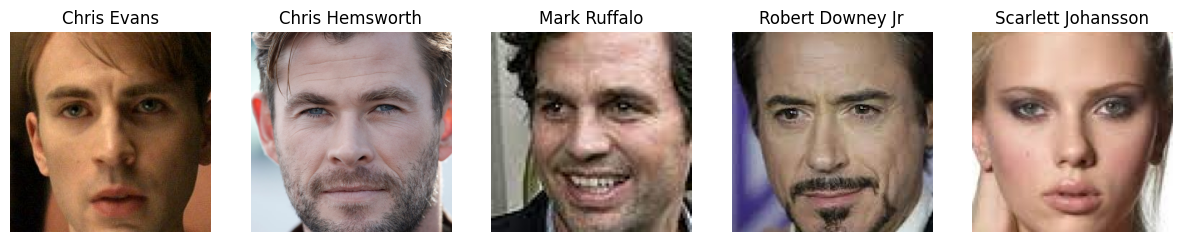

In [2]:
# Setting the directory path where the images are stored
database_dir =  "Data/Images/Database Images"

# Defining a list of class names for each Avenger
class_names = ["Chris Evans", "Chris Hemsworth", "Mark Ruffalo", "Robert Downey Jr", "Scarlett Johansson"]

# Initializing an empty list to store the image paths
images = []

# Looping through each class name
for class_name in class_names:
    
    # Getting a list of image files in the class directory
    image_files = os.listdir(os.path.join(database_dir, class_name))
    
    # Selecting a random image file from the list
    image_file = random.choice(image_files) 
    
    # Appending the path of the selected image to the images list
    images.append(os.path.join(database_dir, class_name, image_file)) 
    
# Creating a figure to display the selected images
fig, ax = plt.subplots(1, 5, figsize = (15, 4))

for i in range(5):
    
    ax[i].imshow(plt.imread(images[i]))
    ax[i].set(title = class_names[i])
    ax[i].axis('off');

## Data Labelling

In [3]:
# Defining a function to get the label of an image
def get_label(image_path):
    
    # List of actor names to use as class labels  
    actor_names = ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']
    
    # Looping through each actor name in the list
    for actor_name in actor_names:
        
        # Checking if the current actor name is present in the image path
        if actor_name in image_path:
            
            # If the actor name is present, return its index as the label
            return actor_names.index(actor_name)
        
        else:
            
          # If the actor name is not present, continue to the next iteration of the loop
          continue

## Face Recognition

In [4]:
# Defining a function to perform image recognition
def face_recognition(image_path):
    
    # Getting the true label of the input image
    true_label = get_label(image_path)

    # Using the DeepFace library to perform face recognition on the input image
    result = DeepFace.find(img_path = image_path,
                            db_path = 'Data/Images/Database Images',
                            model_name = 'ArcFace',
                            distance_metric = 'euclidean_l2',
                            enforce_detection = False)
    
    # Extracting the path of the top predicted image from the result    
    pred_file_path = result[0]['identity'][0]
    
    # Getting the predicted label of the top predicted image
    pred_label = get_label(pred_file_path)

    # Checking if the true label and the predicted label match
    recognition = true_label == pred_label
    
    # Returning a dictionary with the recognition result and the true and predicted labels
    return {'Recognition': recognition, 'True Label': true_label, 'Pred Label': pred_label}

There are  224  representations found in  representations_arcface.pkl
find function lasts  1.7943165302276611  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.12006020545959473  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.12024569511413574  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.14204168319702148  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.13494253158569336  seconds


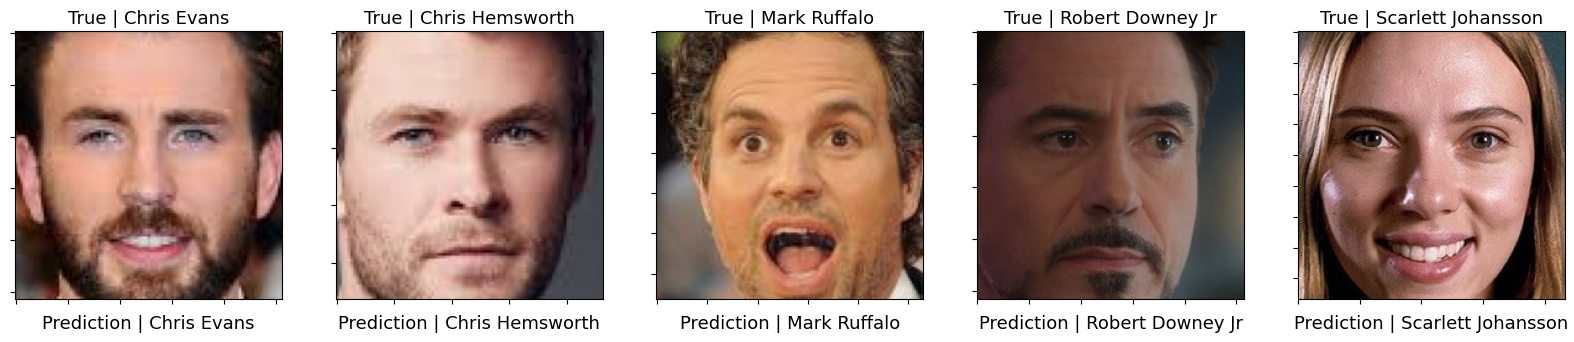

In [5]:
# Setting the path to the directory containing the test images
test_image_dir = 'Data/Images/Test Images'

# Initializing an empty list to store the paths of the test images
image_paths = []

# Looping through each actor directory in the test image directory
for actor_dir in class_names:

    # Constructing the path to the current actor directory in the test image directory
    actor_path = os.path.join(test_image_dir, actor_dir)

    # Selecting a random image file from the current actor directory
    image_file = random.choice(os.listdir(actor_path))

    # Constructing the path to the selected image file
    image_path = os.path.join(actor_path, image_file)

    # Adding the image path to the list of test image paths 
    image_paths.append(image_path)

# Creating a 1x5 grid of subplots to display the test images and their recognition results
fig, axes = plt.subplots(ncols = 5, figsize = (20, 4))

# Looping through each image path in the list of test image paths
for i, image_path in enumerate(image_paths):

    # Performing image recognition on the current test image
    recognition_result = face_recognition(image_path) # Performing image recognition on the current test image
    
    # Getting the true and pred labels of the current test image
    true_label = class_names[recognition_result['True Label']]
    pred_label = class_names[recognition_result['Pred Label']] 
    
    # Displaying the current test image and its recognition result in the appropriate subplot
    axes[i].imshow(plt.imread(image_path))  
    axes[i].set_title(f'True | {true_label}', fontsize = 13)
    axes[i].set_xlabel(f'Prediction | {pred_label}', fontsize = 13)
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([]);

## Evaluation

In [6]:
# Initializing empty lists to store the true and predicted labels of the test images
true_labels = []
pred_labels = []

# Looping through each actor directory in the test image directory
for actor_dir in os.listdir(test_image_dir):

    # Constructing the path to the current actor directory 
    actor_path = os.path.join(test_image_dir, actor_dir)
    
    # Looping through each image file in the current actor directory
    for image_path in glob.glob(os.path.join(actor_path, '*')):
        
        # Getting the true label of the current test image and appending it to true_labels
        true_label = get_label(image_path)
        true_labels.append(true_label)

        # Performing image recognition on the current test image
        recognition_result = face_recognition(image_path)
        
        # Getting the predicted label of the current test image and appending it to pred_labels
        pred_label = recognition_result['Pred Label']
        pred_labels.append(pred_label)

There are  224  representations found in  representations_arcface.pkl
find function lasts  0.12810397148132324  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.11117887496948242  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.11630964279174805  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.12041640281677246  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.12558603286743164  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.12821173667907715  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.11813116073608398  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.3034834861755371  seconds
There are  224  representations found in 

find function lasts  0.13207173347473145  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.13008546829223633  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.2601809501647949  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.14159631729125977  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.13247108459472656  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.1529221534729004  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.14102768898010254  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.13205647468566895  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.14197015762329102  

find function lasts  0.22342967987060547  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.13342523574829102  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.28868865966796875  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.16856956481933594  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.16445016860961914  seconds
There are  224  representations found in  representations_arcface.pkl
find function lasts  0.16443324089050293  seconds


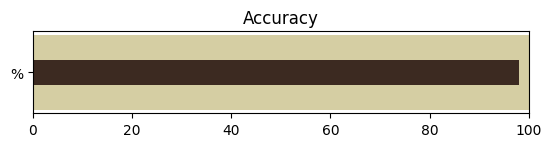

In [7]:
# Calculating the accuracy of the face recognition model on the test images
accuracy = accuracy_score(true_labels, pred_labels) * 100

# Creating a horizontal bar chart to visualize the accuracy of the model
fig, ax = plt.subplots()

# Creating a horizontal bar at the bottom of the chart to represent 100% accuracy
ax.barh([1], 100, left = 0, height = 15, color="#D5CEA3")

# Creating a horizontal bar above the bottom bar to represent the actual accuracy of the model
ax.barh([1], accuracy, color="#3C2A21", height = 5);

ax.set_aspect('equal')
ax.set_yticks([1])
ax.set_yticklabels('%')
ax.set_xlim(0, 100)
ax.set(title = 'Accuracy');

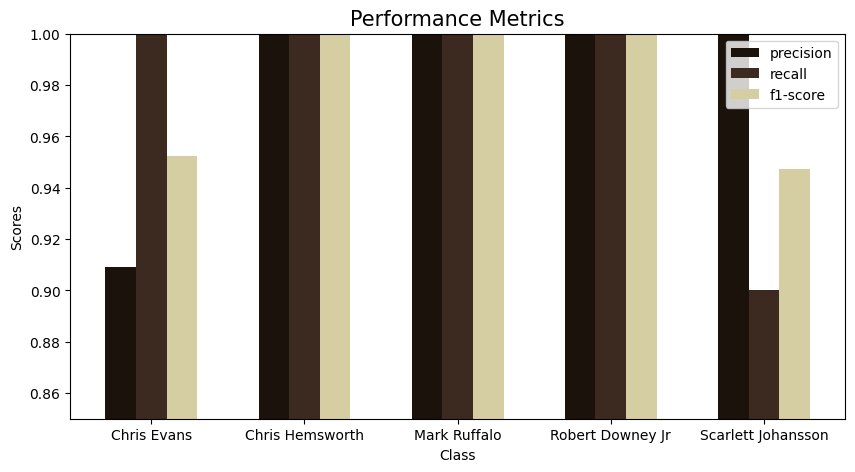

In [8]:
# Calculate classification report for test images
report = classification_report(true_labels, pred_labels, output_dict = True)

# Define metrics to be used
metrics = ["precision", "recall", "f1-score"]

# Initializing empty list to store metric score for each class
class_scores = []

# Extract scores for each class and for each metric
for i in range(5):
    
    class_scores.append([report[str(i)][metric] for metric in metrics])
 
# Create a horizontal bar chart for each metric for each class
fig, ax = plt.subplots(figsize = (10, 5))

bar_width = 0.2

for i, scores in enumerate(class_scores):
    ax.bar(i - bar_width, scores[0], bar_width, color = "#1A120B")
    ax.bar(i, scores[1], bar_width, color = "#3C2A21")
    ax.bar(i + bar_width, scores[2], bar_width, color = "#D5CEA3")

ax.set_xlabel("Class")
ax.set_ylabel("Scores")
ax.set_ylim(0.85, 1)
ax.legend(metrics)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(class_names)
ax.set_title("Performance Metrics", fontsize = 15);

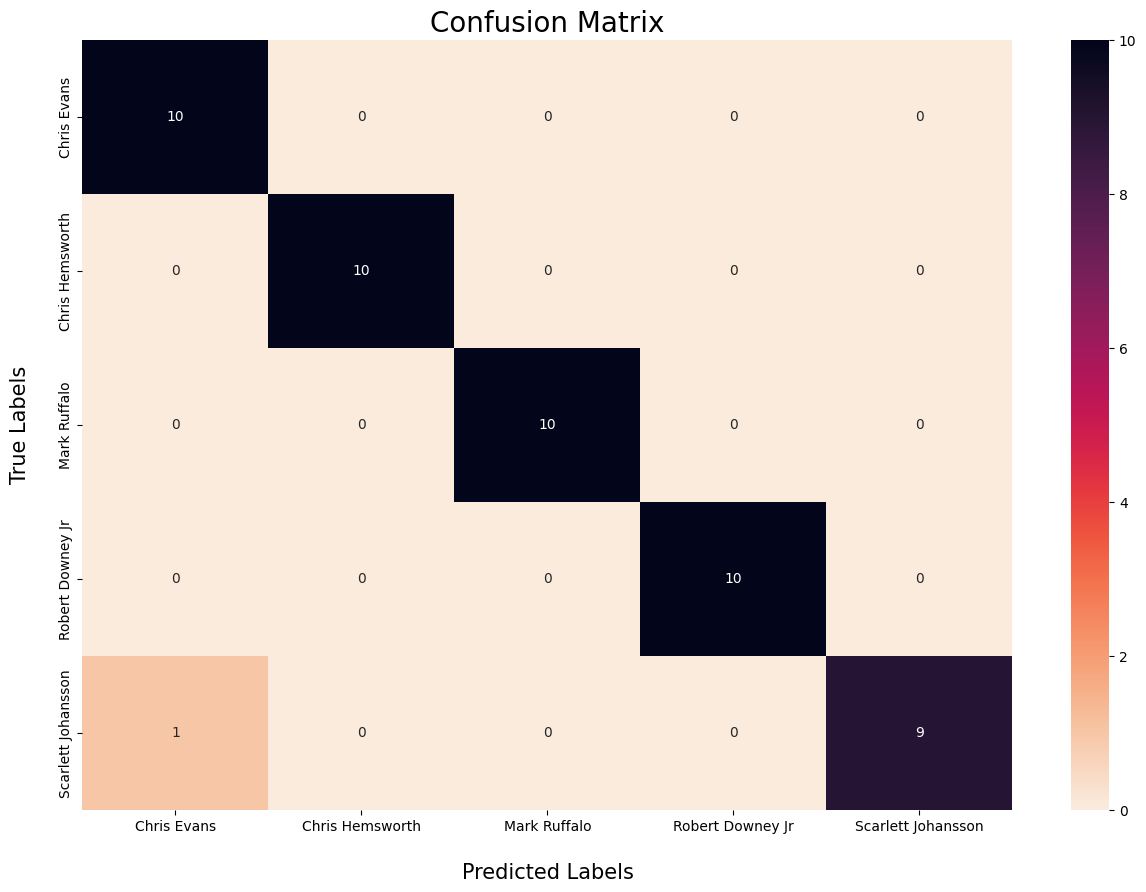

In [9]:
# Generate the confusion matrix 
cm = tf.math.confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(cm, annot=True, fmt='', ax = ax, cmap = 'rocket_r')

ax.set_yticklabels(class_names, va="center")
ax.set_xticklabels(class_names, ha="center")
ax.set_xlabel('\nPredicted Labels', fontsize = 15)
ax.set_ylabel('True Labels\n', fontsize = 15)

plt.title("Confusion Matrix", fontsize = 20);